# K-Means

K-means algorithm implemented in different ways
- Lloyd's alogrithm (expectation maximisation)
- Hard K-Means gradient descent
- Soft K-Means gradient descent

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.datasets import make_blobs

sns.set_style('darkgrid')
%matplotlib inline
np.random.seed(42)

Given $n$ observations [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering aims to partition these observations into $k$ ($\leq n$) sets $\mathbf{S} =\{S_i \ldots S_k\}$ with to goal to minimize the within-cluster sum of squares.

$$
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}
$$

Since [variance](https://en.wikipedia.org/wiki/Variance) of cluster $S_i$ is:
$$
Var(S_i) = \frac{1}{|S_i|} \sum _{\mathbf {x} \in S_{i}}(\mathbf {x} -{\boldsymbol {\mu }}_{i})^{2}
$$

We can also say that k-means minmizes the within-cluster variance:
$$
{\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}
$$

In [2]:
k = 3
print('k: ', k)

# Create data
X, y = make_blobs(
    n_samples=1000, n_features=2, cluster_std=3, centers=k,
    random_state=42, shuffle=True)

k:  3


In [3]:
# Initial centroids
# bad initial condition where initial centroids are close together
# initial_centroids = np.asarray([[10.1,10.1],[9.9, 9.9],[10., 10.]])  # Fails for Lloyds algo
initial_centroids = np.asarray([[0.00001, 0.0001],[-0.00001, 0.00001],[0., 0.]])
# For regular initialisation use:
# initial_centroids = X[np.random.choice(X.shape[0], k, replace=False), :]

print('initial_centroids: ', initial_centroids)

initial_centroids:  [[ 1.e-05  1.e-04]
 [-1.e-05  1.e-05]
 [ 0.e+00  0.e+00]]


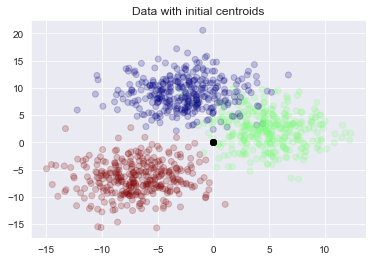

X:  (1000, 2)


In [4]:
cmap = cm.jet
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=0.2)
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], c='black')
plt.title('Data with initial centroids')
plt.show()
print('X: ', X.shape)

## LLoyd's algorithm

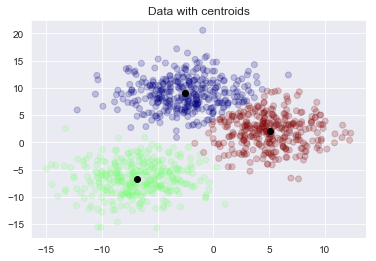

In [5]:
centroids = initial_centroids.copy()
centroids = np.expand_dims(centroids, 1)
# Run k-means Lloyd's algorithm
X_expand = np.expand_dims(X, 0)
for _ in range(10):
    distances = np.sum(
        (X_expand - centroids) ** 2, axis=2)
    allocated_idx = np.argmin(distances, axis=0)
    for i in range(k):
        centroids[i, 0, :] = np.mean(X[allocated_idx==i, :], axis=0)
        
        
# Plot results
plt.scatter(X[:, 0], X[:, 1], c=allocated_idx, cmap=cmap, alpha=0.2)
plt.scatter(centroids[:, 0, 0], centroids[:, 0, 1], c='black')
plt.title('Data with centroids')
plt.show()

## Gradient update

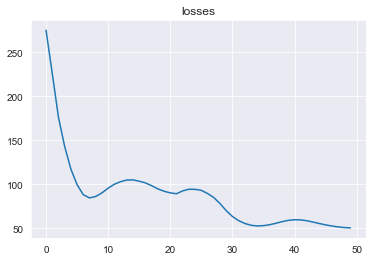

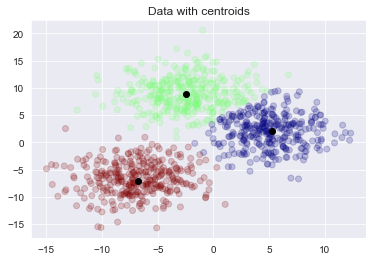

In [6]:
losses = []

graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    # Setup input
    centroids = tf.Variable(initial_centroids.copy())
    X_expand = tf.expand_dims(X, 0)
    centroids_expand = tf.expand_dims(centroids, 1)
    # Compute distances
    distances = tf.reduce_sum(
        (X_expand - centroids_expand) ** 2, axis=2)
    # Select clusters
    allocated_idx = tf.cast(tf.argmin(distances, axis=0), tf.int32)
    # Partition into clusters
    partitions = tf.dynamic_partition(tf.transpose(distances), allocated_idx, num_partitions=k)
    # Add loss per partition
    loss = tf.zeros((), dtype=tf.float64)
    for i in range(k):
        ik = tf.reduce_mean(partitions[i][:,i], axis=0)
        loss += ik
    # Define optimization
    optimizer = tf.train.AdamOptimizer(learning_rate=1.)
    global_step = tf.train.get_or_create_global_step()
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Init and run
    sess.run(tf.global_variables_initializer())
    # Run training
    for step in range(50):
        loss_value , _ = sess.run([loss, train_op])
        losses.append(loss_value)
    final_centroids, allocated_idx = sess.run([centroids, allocated_idx])
    

# Plot losses
plt.plot(losses)
plt.title('losses')
plt.show()

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=allocated_idx, cmap=cmap, alpha=0.2)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='black')
plt.title('Data with centroids')
plt.show()

## Soft clustering

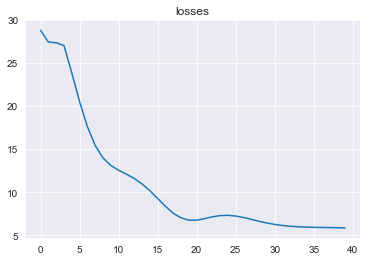

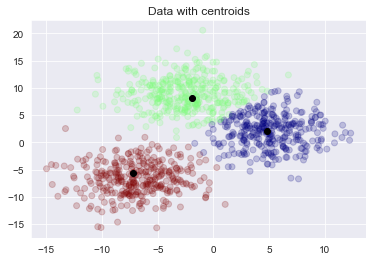

In [7]:
losses = []
beta = 1

graph = tf.Graph()
with tf.Session(graph=graph) as sess:
    # Define loss
    centroids = tf.Variable(initial_centroids.copy())
    X_expand = tf.expand_dims(X, 0)
    centroids_expand = tf.expand_dims(centroids, 1)
    distances = tf.transpose(tf.reduce_sum(
        (X_expand - centroids_expand) ** 2, axis=2))
    # Soft weighting based on softmax
    softmax = tf.nn.softmax(-(1./beta)*distances, axis=1)
    weighted_distance = distances * softmax
    loss = tf.reduce_mean(weighted_distance)
    # Define optimization
    optimizer = tf.train.AdamOptimizer(learning_rate=1)
    global_step = tf.train.get_or_create_global_step()
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Init and run
    sess.run(tf.global_variables_initializer())
    # Run training
    for step in range(40):
        loss_value , _ = sess.run([loss, train_op])
        losses.append(loss_value)
    allocated_idx = tf.argmax(softmax, axis=1)
    final_centroids, allocated_idx = sess.run([centroids, allocated_idx])


# Plot losses
plt.plot(losses)
plt.title('losses')
plt.show()

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=allocated_idx, cmap=cmap, alpha=0.2)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='black')
plt.title('Data with centroids')
plt.show()